# The Goal
- Branching off previous results, compare random ovesampling, SMOTE oversampling, and a combintion of random udersampling and SMOTE oversampling.

## Step 1: Reproduce random oversmapling results.

In [1]:
from config import *

Using TensorFlow backend.


In [23]:
df = pd.read_csv('./creditcard.csv')
X = df.drop('Class', axis=1).values
Y = df.Class.values

seed = 1234
tf.random.set_seed(seed)

x, x_test, y, y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.15, shuffle=True, random_state=seed)

# applying random oversampling
ros = RandomOverSampler(random_state=seed)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

## Step 2: Apply SMOTE oversampling

In [24]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

## Step 3: Apply random undersampling,then SMOTE oversampling

In [59]:
rus = RandomUnderSampler(random_state=seed, replacement=True)
x_train_rus, y_train_rus = rus.fit_resample(x_train, y_train)
x_train_rus_smote, y_train_rus_smote = smote.fit_resample(x_train_rus, y_train_rus)

### Visualize Results

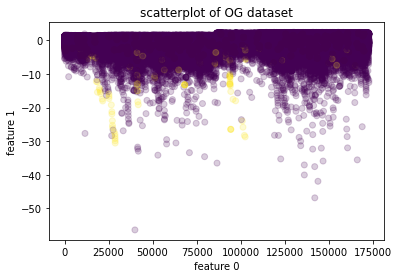

In [52]:
plt.scatter(x_train[:,0], x_train[:,1], alpha=0.2,
           c=y_train, cmap='viridis')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.title("scatterplot of OG dataset")
plt.show()

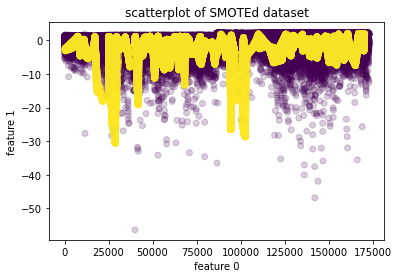

In [55]:
plt.scatter(x_train_smote[:,0], x_train_smote[:,1], alpha=0.2,
           c=y_train_smote, cmap='viridis')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.title("scatterplot of SMOTEd dataset")
plt.show()

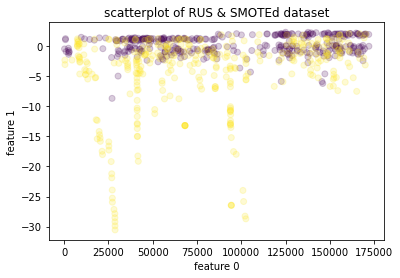

In [60]:
plt.scatter(x_train_rus_smote[:,0], x_train_rus_smote[:,1], alpha=0.2,
           c=y_train_rus_smote, cmap='viridis')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.title("scatterplot of RUS & SMOTEd dataset")
plt.show()

## Step 4: Train logistic regression, NN, and xgb on SMOTE training set

In [62]:
## logistic regression

# building model framework
lgmodel_v4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lgmodel_v4.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_lgmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

lgmodel_v4.fit(
    x_train_smote, y_train_smote,
    epochs=25, # reduced epochs from observations of plateau in last experiment
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(lgmodel_v4.summary())
print(lgmodel_v4.to_json())

Train on 410818 samples, validate on 36313 samples
Epoch 1/25
410818/410818 [==============================] - 22s 53us/sample - loss: 16.6819 - binary_accuracy: 0.8900 - precision_1: 0.8818 - recall_1: 0.9007 - val_loss: 51.4101 - val_binary_accuracy: 0.3020 - val_precision_1: 0.0019 - val_recall_1: 1.0000
Epoch 2/25
410818/410818 [==============================] - 22s 55us/sample - loss: 10.1713 - binary_accuracy: 0.9411 - precision_1: 0.9362 - recall_1: 0.9466 - val_loss: 1.6915 - val_binary_accuracy: 0.9880 - val_precision_1: 0.0928 - val_recall_1: 0.9167
Epoch 3/25
410818/410818 [==============================] - 20s 48us/sample - loss: 10.1055 - binary_accuracy: 0.9489 - precision_1: 0.9453 - recall_1: 0.9529 - val_loss: 21.9527 - val_binary_accuracy: 0.7567 - val_precision_1: 0.0052 - val_recall_1: 0.9583
Epoch 4/25
410818/410818 [==============================] - 19s 45us/sample - loss: 9.7744 - binary_accuracy: 0.9534 - precision_1: 0.9502 - recall_1: 0.9570 - val_loss: 2.2225

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

In [66]:
## NN

# building model framework
nnmodel_v4 = tf.keras.models.Sequential([
        Dense(units=x_train_smote.shape[1], activation='relu'),
        Dense(units=15, activation='relu'),
        Dense(units=5, activation='relu'),
        Dense(units=1, activation='sigmoid'),
])

nnmodel_v4.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_nnmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

nnmodel_v4.fit(
    x_train_smote, y_train_smote,
    epochs=25, # reduced epochs based on results from last experiment
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(nnmodel_v4.summary())
print(nnmodel_v4.to_json())

In [124]:
%load_ext tensorboard
%tensorboard --logdir logs/{NAME}

Reusing TensorBoard on port 6006 (pid 3599), started 1:23:38 ago. (Use '!kill 3599' to kill it.)

In [69]:
## xgboost

xgbmodel_v4 = XGBClassifier(n_estimators=100)
xgbmodel_v4.fit(x_train_smote, y_train_smote)

/Users/solinakim/opt/anaconda3/envs/mypython3.6/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Step 5: Train logistic regression, NN, and xgb on RUS + SMOTE training set

In [70]:
## logistic regression

# building model framework
lgmodel_v5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lgmodel_v5.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_lgmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

lgmodel_v5.fit(
    x_train_rus_smote, y_train_rus_smote,
    epochs=25, # reduced epochs from observations of plateau in last experiment
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(lgmodel_v5.summary())
print(lgmodel_v5.to_json())

In [71]:
## NN

# building model framework
nnmodel_v5 = tf.keras.models.Sequential([
        Dense(units=x_train_rus_smote.shape[1], activation='relu'),
        Dense(units=15, activation='relu'),
        Dense(units=5, activation='relu'),
        Dense(units=1, activation='sigmoid'),
])

nnmodel_v5.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

NOW = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
NAME = f"creditcard_fraud_nnmodel_{NOW}"
tensorboard = TensorBoard(log_dir=f'./logs/{NAME}', histogram_freq=1)

logging.getLogger("tensorflow").setLevel(logging.ERROR)

nnmodel_v5.fit(
    x_train_rus_smote, y_train_rus_smote,
    epochs=25, # reduced epochs based on results from last experiment
    callbacks = [tensorboard],
    validation_data = (x_cv, y_cv),
)

sys.stdout = open(f'./logs/{NAME}/config.txt', 'w')
print(nnmodel_v5.summary())
print(nnmodel_v5.to_json())

In [72]:
## xgboost

xgbmodel_v5 = XGBClassifier(n_estimators=100)
xgbmodel_v5.fit(x_train_rus_smote, y_train_rus_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Step 5: Compare Results

In [73]:
# save and load models

lgmodel_v4.save('./models/lgmodel_v4')
nnmodel_v4.save('./models/nnmodel_v4')
xgbmodel_v4.save_model('./models/xgbmodel_v4.json')
lgmodel_v5.save('./models/lgmodel_v5')
nnmodel_v5.save('./models/nnmodel_v5')
xgbmodel_v5.save_model('./models/xgbmodel_v5.json')

# loading random oversampling model
lgmodel_v3 = tf.keras.models.load_model('./models/lgmodel_v3')
nnmodel_v3 = tf.keras.models.load_model('./models/nnmodel_v3')
xgbmodel_v3 = XGBClassifier()
xgbmodel_v3.load_model('./models/xgbmodel_v3.json')

In [113]:
models = [lgmodel_v3, lgmodel_v4, lgmodel_v5, nnmodel_v3, nnmodel_v4, nnmodel_v5,
          xgbmodel_v3, xgbmodel_v4, xgbmodel_v5]
NUM_MODELS = len(models)

pred_probs = {}
pred = {}
cm = {}

# making predictions
for index,model in enumerate(models):
    PREDNAME = (str(index)+ '_cv_preds_probs')
    pred_probs[PREDNAME] = model.predict(x_cv)

# converting probabilities to binary classes
binclass_threshold = 0.5
for i in range(0,6):
    PROBNAME = (str(i) + '_cv_preds_probs')
    PREDNAME = (str(i) + '_cv_preds')
    pred[PREDNAME] = (pred_probs[PROBNAME] >= binclass_threshold).astype(int)
for i in range(6,NUM_MODELS):
    PROBNAME = (str(i) + '_cv_preds_probs')
    PREDNAME = (str(i) + '_cv_preds')
    pred[PREDNAME] = pred_probs[PROBNAME]

# generating confusion matrices
for i in range(0,NUM_MODELS):
    p = pred[str(i) + '_cv_preds']
    cm[str(i) + '_cm'] = confusion_matrix(y_cv, p)


In [121]:
# f1 scores
display('========F1 SCORES========')
display('========with random oversampling')
display(f'logistic regression: {f1_score(y_cv, pred["0_cv_preds"])}')
display(f'neural networks: {f1_score(y_cv, pred["3_cv_preds"])}')
display(f'xgboost: {f1_score(y_cv, pred["6_cv_preds"])}')
display('========with SMOTE oversampling')
display(f'logistic regression: {f1_score(y_cv, pred["1_cv_preds"])}')
display(f'neural networks: {f1_score(y_cv, pred["4_cv_preds"])}')
display(f'xgboost: {f1_score(y_cv, pred["7_cv_preds"])}')
display('========with RUS + SMOTE oversampling')
display(f'logistic regression: {f1_score(y_cv, pred["2_cv_preds"])}')
display(f'neural networks: {f1_score(y_cv, pred["4_cv_preds"])}')
display(f'xgboost: {f1_score(y_cv, pred["8_cv_preds"])}')

'========F1 SCORES========'

'========with random oversampling'

'logistic regression: 0.15492957746478875'

'neural networks: 0.0'

'xgboost: 0.8936170212765957'

'========with SMOTE oversampling'

'logistic regression: 0.1785714285714286'

'neural networks: 0.0'

'xgboost: 0.8775510204081632'

'========with RUS + SMOTE oversampling'

'logistic regression: 0.09950248756218905'

'neural networks: 0.0'

'xgboost: 0.06540697674418605'

In [122]:
# roc-auc scores

display('========RECEIVER OPERATING CHARACTERISTIC CURVE (ROC AUC)========')
display('========with random oversampling')
display(f'logistic regression: {roc_auc_score(y_cv, pred["0_cv_preds"])}')
display(f'neural networks: {roc_auc_score(y_cv, pred["3_cv_preds"])}')
display(f'xgboost {roc_auc_score(y_cv, pred["6_cv_preds"])}')
display('========with SMOTE oversampling')
display(f'logistic regression: {roc_auc_score(y_cv, pred["1_cv_preds"])}')
display(f'neural networks: {roc_auc_score(y_cv, pred["4_cv_preds"])}')
display(f'xgboost {roc_auc_score(y_cv, pred["7_cv_preds"])}')
display('========with RUS + SMOTE oversampling')
display(f'logistic regression: {roc_auc_score(y_cv, pred["2_cv_preds"])}')
display(f'neural networks: {roc_auc_score(y_cv, pred["5_cv_preds"])}')
display(f'xgboost {roc_auc_score(y_cv, pred["8_cv_preds"])}')


'========RECEIVER OPERATING CHARACTERISTIC CURVE (ROC AUC)========'

'========with random oversampling'

'logistic regression: 0.9517705317339951'

'neural networks: 0.5'

'xgboost 0.9374448504067283'

'========with SMOTE oversampling'

'logistic regression: 0.9630833792913276'

'neural networks: 0.5'

'xgboost 0.9478201548784412'

'========with RUS + SMOTE oversampling'

'logistic regression: 0.7037283422951423'

'neural networks: 0.7641050829541797'

'xgboost 0.9510607679580863'

Text(0.5, 1.0, 'xgboost with RUS +SMOTE oversampling cf matrix')

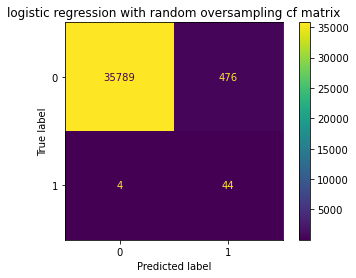

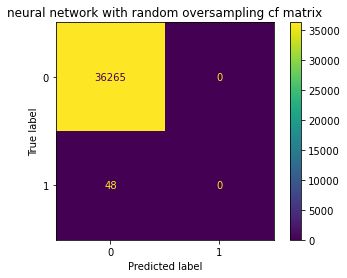

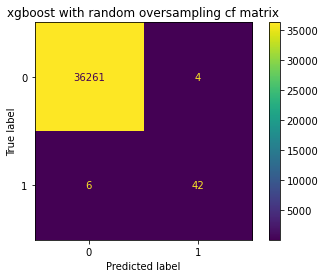

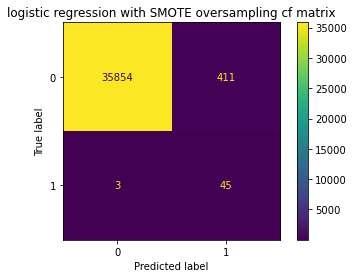

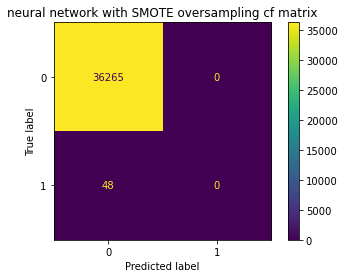

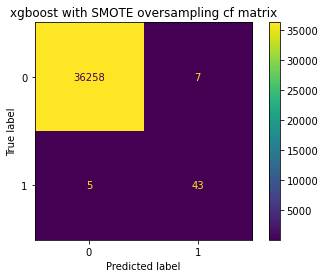

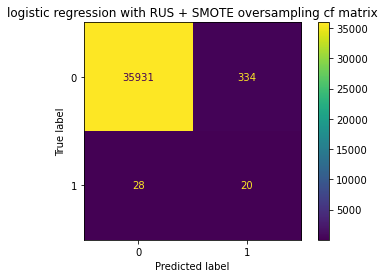

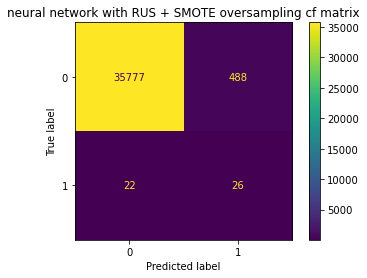

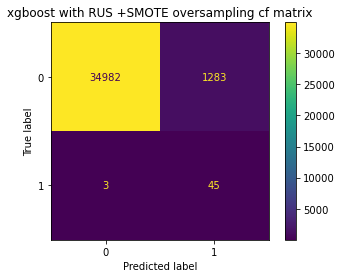

In [123]:
# confusion matrices
dp1 = ConfusionMatrixDisplay(confusion_matrix=cm['0_cm'])
dp1.plot()
dp1.ax_.set_title('logistic regression with random oversampling cf matrix')

dp2 = ConfusionMatrixDisplay(confusion_matrix=cm['3_cm'])
dp2.plot()
dp2.ax_.set_title('neural network with random oversampling cf matrix')

dp3 = ConfusionMatrixDisplay(confusion_matrix=cm['6_cm'])
dp3.plot()
dp3.ax_.set_title('xgboost with random oversampling cf matrix')

dp4 = ConfusionMatrixDisplay(confusion_matrix=cm['1_cm'])
dp4.plot()
dp4.ax_.set_title('logistic regression with SMOTE oversampling cf matrix')

dp5 = ConfusionMatrixDisplay(confusion_matrix=cm['4_cm'])
dp5.plot()
dp5.ax_.set_title('neural network with SMOTE oversampling cf matrix')

dp6 = ConfusionMatrixDisplay(confusion_matrix=cm['7_cm'])
dp6.plot()
dp6.ax_.set_title('xgboost with SMOTE oversampling cf matrix')


dp7 = ConfusionMatrixDisplay(confusion_matrix=cm['2_cm'])
dp7.plot()
dp7.ax_.set_title('logistic regression with RUS + SMOTE oversampling cf matrix')

dp8 = ConfusionMatrixDisplay(confusion_matrix=cm['5_cm'])
dp8.plot()
dp8.ax_.set_title('neural network with RUS + SMOTE oversampling cf matrix')

dp9 = ConfusionMatrixDisplay(confusion_matrix=cm['8_cm'])
dp9.plot()
dp9.ax_.set_title('xgboost with RUS +SMOTE oversampling cf matrix')


## Conclusion
- SMOTE improved ROC-AUC scores in logistic regression and xgboost by 1-2%
- RUS, even combined with SMOTE does not seem fit for current dataset
- xgboost model seems to be performing extremely well with F1 = 0.894, ROC-ACU = 0.948 (xgbmodel_v4).
- For the logistic regression model, hyperparameter tuning seems necessary for better performance, targeting the overfitting problem.
- For the neural network, a more complex neural architecture seems needed.

### Next Steps:
- Explore regularization and hyperparamter tuning in logistic regression to improve model performance.